# <center>  Modeling Interphase Convection Heat Transfer in a Packed Bed Reactor </center>

<center>Keith King</center>

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0009250916306005-fx1.jpg" width="35%">
<p style="text-align: right;">Image from: https://www.sciencedirect.com/science/article/pii/S0009250916306005</p>

---
# Authors

1. Keith King

---
# Abstract

Porous materials play critical roles in key engineering thermo-fluid processes (oil exploration, industrial chemical manufacturing, air and water filtration, etc.). It is therefore crucial to model the behavior of different systems (geometries, thermal conditions, flow conditions, and material compositions). System modeling requires knowledge of the convective heat transfer coefficient that controls the heat exchanged between the solid phase and the fluid phase inside the porous structure. This parameter is determined through a combined experimental and modeling effort. On the modeling side, one must be able to solve for the thermal field inside a porous material under specified flow conditions for a given heat transfer coefficient. This combines with experimental results to iteratively minimize the error between measured data and modeled data, adjusting the heat transfer coefficient used in the model until the data and model results match. This software forms the core of that optimization program by allowing one to solve for the thermal field at steady-state conditions. It utilizes the two-dimensional Navier-Stokes partial differential equations. These equations have been derived based on the volume-averaging theory for porous materials and are then converted to an algebraic, second-order accurate finite difference form. This generates a system of linear equations that is solved directly by matrix inversion. The result is the separate steady-state temperature fields for the solid and fluid phases that can then be used for a plethora of purposes.

----
# Statement of Need

This software was constructed to model the steady-state temperature field of a porous material under steady heat flux and steady fully-developed flow to aid in measuring the interstitial heat transfer coefficient for a packed bed of cylindrical particles.

----
# Installation instructions

This software can be installed by running the following commands in the terminal (commands inside quotations):

- Create the conda environment using the provided environment file that contains all of the needed Python libraries "conda env create -f environment.yml"
- Activate the environment: "conda activate myenv"
- Verify that the environment was installed correctly by making sure it is present: "conda env list"

Make sure that the library file "porous_material_convection.py" is downloaded in the working directory. Once so, you can import the file by running "import porous_material_convection as pmc" and can then begin working with the code.

----
# Unit Tests

The testing programs for this software are included in the code cell below. 
- Test 1 is designed to make sure that the pellet geometric factors are calculated correctly by the equations. If the core equations are modified for a different geometry (such as spherical particles), the correct values should be calculated using the test values and the test function updated to reflect that.
- Test 2 is designed to make sure that the air property equations are correct so that the correct inlet conditions are used.
- Test 3 makes sure that the average velocity is calculated correctly.
- Test 4 makes sure that the linear system is (a) populated correctly so that the matrix is non-zero, (b) makes sure that the assembled system is square, and (c) makes sure that the assembled system has consistent dimensions.

To use these functions, move into the "tests" folder in the terminal, then run the following command: "pytest test_porous_material_convection.py" and the tests should all be run at once in the terminal.

In [1]:
#Test functions for the porous medium heat transfer thermal field modeling software.
import pytest
import numpy as np
from porous_material_convection import porous_material_convection

# Test 1
def test_pellet_geometry_factors():
    #Make sure that the equations for the pellet geometry are calculating correct values.
    assert porous_material_convection.pellet_geometry_factors(1,1,0.5) == (0.001,3000.0)
    
# Test 2
def test_air_properties():
    # Call the air properties function.
    x,y = porous_material_convection.air_properties(25,1)
    # Check if values are correct.
    assert x > 1.18 and x < 1.19
    assert y > 1.8e-5 and y < 1.9e-5

# Test 3
def test_mean_velocity():
    #Make sure the velocity is being correctly calculated.
    assert porous_material_convection.mean_velocity(1,2,1,0.5) == 1

#Test 4
def test_assemble_linear_system():
    #Make sure that the system of equations is being assembled correctly.
    (A,RHS) = porous_material_convection.assemble_linear_system(1,0.1,10,10,0.5,10,1,10,2,1,25,10,10) 
    assert A.shape == (200,200)
    assert RHS.shape == (200,1)
    assert np.sum(A) > 0
    assert np.sum(RHS) > 0  

----
# Example usage

This section is copied from the guided example notebook included in the software. It contains a cell-by-cell example of how to use the basics of this library. Values chosen do not necessarily have any real association and are just numbers chosen to facilitate an example. When using this library, make sure that all of your properties, dimensions, and conditions are physically accurate and consistent with your physical setup and the materials involved in your system.

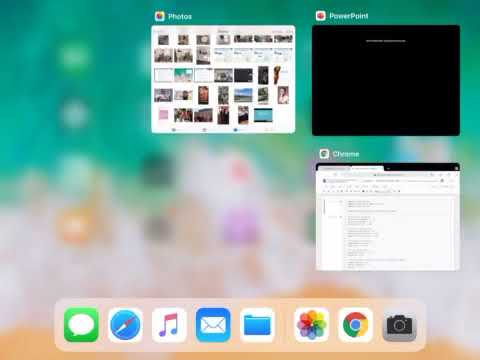

In [2]:
# Watch this video if you want to get a little background information into the theory and motivation behind this project!

from IPython.display import YouTubeVideo
YouTubeVideo('asnO85gfLm8',width=640,height=360)

In [10]:
# Import modules that you'll need to use the software and view the results.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Import the software itself.
import porous_material_convection.porous_material_convection as pmc

In [11]:
# THIS CELL HANDLES THE PHYSICAL GEOMETRY OF THE SYSTEM.

# Define the geometry of the cylindrical particles within your packed bed in millimeters. Note that if you want to use a 
# different porous material geometry, you'll have to go into the pellet_geometry_factors function and change the geometry
# equations.

particle_diameter = 3.5
particle_height = 2.5

#Define the bulk porosity of the system.
bulk_porosity = 0.38

# Calculate the hydraulic diameter needed for fluid velocity calculations and the accesible surface area per 
# unit volume of the bed needed for heat transfer calculations.
hyd_dia, surf_area = pmc.pellet_geometry_factors(particle_diameter,particle_height,bulk_porosity)

In [12]:
# THIS CELL HANDLES THE PROPERTIES OF THE FLUID FLOWING THROUGH THE BED AND CALCULATES THE MEAN FLUID VELOCITY.

# NOTE: this function is designed to calculate properties of air, but can be modified or replaced to calculate the needed
# fluid properties for a different gas or liqud if desired.

# Define the inlet conditions of your air, i.e., temperature and pressure. Temperature is in °C and pressure is a 
# percentage of absolute. For example, if you have an inlet pressure of 3 bar, then enter 3.
Temperature_inlet = 25
Pressure_inlet = 1.25

# Calculate the density and viscosity of the air.
density, viscosity = pmc.air_properties(Temperature_inlet, Pressure_inlet)


# Define the Reynolds number you want in your system. This parameter contains information about the flow conditions and 
# is used here to calculate the mean velocity needed for the thermal field solver.

Reynolds = 50

# Calculate the mean velocity.
Vel = pmc.mean_velocity(Reynolds, density, viscosity, hyd_dia)

In [13]:
# THIS CELL CREATES THE SYSTEM OF EQUATIONS TO BE SOLVED TO CALCULATE THE STEADY-STATE THERMAL FIELDS.

# Define the dimensions of your system. The current code is configured for a cylindrical annulus geometry, but 
# this can be easily changed within the "global_coefficient_matrix_assembly" function to use the code for different
# packed bed geometries. Bed dimensions must be entered in meters.

inner_radius = 0.1
outer_radius = 0.25
length = 0.25

# Define the grid mesh for your solver. The solver is set up for a square mesh (equal number of nodes in each direction),
# but this can easily be changed as well in the "global_coefficient_matrix_assembly" function.

nodes = 11

# Define the thermal properties of your packed bed and the fluid flowing through it. Thermal conductivity must be in 
# W/mK, and specific heat must be in J/kgK.
thermal_cond_solid = 12
thermal_cond_fluid = 0.027
specific_heat_fluid = 1006

# Define the boundary conditions for your setup. Note that the software is configured for the application of a constant 
# heat flux at the inner surface and an insulated outer surface. However, this can be changed by replacing the appropriate
# boundary condition loops and indexing structure within the "global_coefficient_matrix_assembly" function if you wish to 
# use different boundary conditions for your system.

#Heat flux, must be in W/m^2
heat_flux = 25000

# Define the heat transfer coefficient for your system. THIS IS WHERE THE SOFTWARE BECOMES MORE USER-FLEXIBLE.
# The base purpose of this software is to calculate the thermal fields for a two-phase (solid and liquid) porous material. 
# This requires information on the internal surface area (interstitial) heat transfer coefficient (HTC). For the purposes 
# of this example, a correlation from the literature is used. However, in real life, this is where a short optimization 
# program could be written to solve for a true HTC from measured temperature field data. If desired to do so, at this 
# point, remove the correlation and begin your optimization with an initial guess of the HTC. Alternatively, if you 
# already have a trustworthy correlation for your HTC, implement that here.

heat_transfer_coefficient = (thermal_cond_fluid/hyd_dia)*(2+1.1*(6*(1-bulk_porosity))**0.6*Reynolds**0.6*(specific_heat_fluid*viscosity/thermal_cond_fluid)**(1/3))

# Use all of the above inputs to create your system of equations to solve.
Coefficient_matrix, Source_vector = pmc.assemble_linear_system(inner_radius,outer_radius,length,nodes,bulk_porosity,
                                                               density,Vel,thermal_cond_solid,thermal_cond_fluid,
                                                               specific_heat_fluid,heat_flux,Temperature_inlet,
                                                               heat_transfer_coefficient,surf_area)

In [14]:
# THIS CELL SOLVES THE LINEAR SYSTEM AND EXTRACTS THE TEMPERATURE FIELDS FOR YOU TO VISUALIZE.

# Solve the system using your created matrices from the previous cell.
Global_temperature = pmc.solve_linear_system(Coefficient_matrix, Source_vector)

# Extract the separate steady-state thermal fields for the solid phase and fluid phase.
Solid_temperature_field, Fluid_temperature_field = pmc.extract_temperature_fields(Global_temperature,nodes)

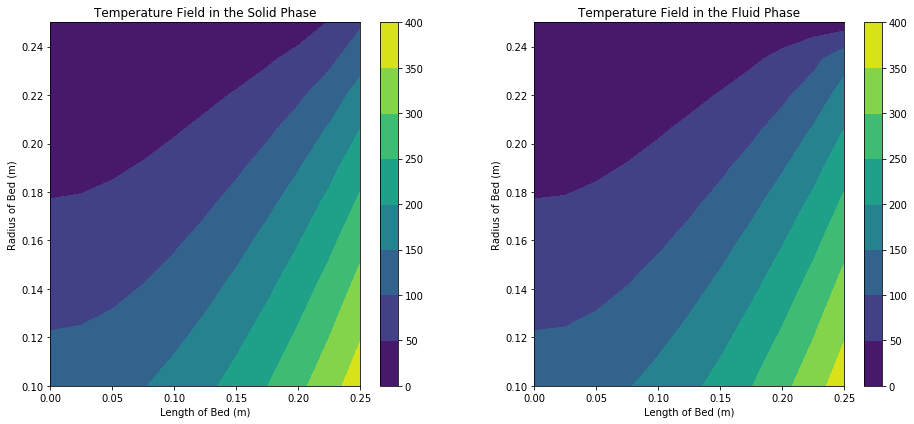

In [15]:
# THIS CELL PRINTS FILLED CONTOUR PLOTS OF THE STEADY-STATE THERMAL FIELDS
# SO THAT YOU CAN SEE WHAT YOUR RESULTS SHOULD LOOK LIKE.

# Create 2D physical domain space vectors for plotting.
R = np.linspace(outer_radius,inner_radius,nodes)
Z = np.linspace(0,length,nodes)

# Create the coordinate grid and plot the temperature fields in a single subplot figure.
Grid_R, Grid_Z = np.meshgrid(R,Z)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,6))

# Set labels for the first subplot and add a colorbar.
solid_temp = ax1.contourf(Grid_Z,Grid_R, Solid_temperature_field)
ax1.set_title('Temperature Field in the Solid Phase')
ax1.set_xlabel('Length of Bed (m)')
ax1.set_ylabel('Radius of Bed (m)')
plt.colorbar(solid_temp,ax = ax1)

# Set labels for the second subplot and add a colorbar.
fluid_temp = ax2.contourf(Grid_Z,Grid_R, Fluid_temperature_field)
ax2.set_title('Temperature Field in the Fluid Phase')
ax2.set_xlabel('Length of Bed (m)')
ax2.set_ylabel('Radius of Bed (m)')
plt.colorbar(fluid_temp,ax = ax2)

# Modify the layout of the subplot to make for nicer viewing.
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

You now have two arrays of temperature data, one for the solid portion of your porous material and one for the fluid flowing within the porous material. You can now use this data for whatever you might want. Here are a few examples:

1. Sizing a new porous material system to get a desired temperature effect.
2. Understanding how using different materials will allow for control of the thermal behavior by varying properties.
3. Figuring out what flow rates the fluid should be to create a desired thermal effect.
4. How much power needs to be entering the system to maintain a steady thermal effect.
5. Changing the geometric parameters (either in this example or within the functions themselves) to look at how different geometries can change your thermal fields.

Enjoy!

---
# Methodology

The final project had a few minor-to-medium differences from the original project proposal. The differences are detailed by bullet point.

- Changes to the Planned Fluid Velocity Solver: Originally, I had planned to write a numerical solution using a Runge-Kutta-based Shooting Method program for the non-linear ODE that is the simplified porous media momentum equation. However, I found two things out: (1) the ODE could be split into two linear ODE's and solved using a built-in ODE solver in Python. I did this, only to find out that (2) the velocity profile is almost entirely uniform across the field (except right at the boundaries). This meant that I could assume a constant velocity calculated from the superficial velocity in the tube and could thus simplify my project by removing this portion.

- Changes to the Solution Method for the Linear System of Equations: I was going to use the Thomas Algorithm (a form of Gaussian elimination) to solve the linear system. This algorithm is meant for speeding up the inversion of the coefficient matrix that is necessary for directly solving a linear system. However, I discovered that my system was small enough that I could just use a built-in inversion function in Python and achieve a solution very quickly. Therefore, I decided to abandon this solution method and use the built-in function in NumPy, thus drastically simplifying my code.

- I chose to forgo the optimization loop for extracting a heat transfer coefficient by minmimizing differences between measured data and predicted data. As of the submission of this project, the experimental work has not been done. The optimization loop is a very simple addition (just a few lines), but since I didn't have experimental data yet, I just decided to skip it. The core and essence of the work is the steady-state thermal field solver, so I focused the project on that.

- Higher-order finite difference equations above second-order accuracy were deemed to be an uneccessary complication and were thus not included.

Other than those four points, the remainder of the project matches quite well with the proposal document. All project requirements have been addressed in this work.


---
# Concluding Remarks

I learned a lot while doing this project. On the modeling side, I learned a ton about how to build rigourous, well-tested, and easy to understand software packages. I also learned a lot of functional skills for programmers, such as version control with Git and how to use the terminal for program and file management. On the science side, I learned a ton about the behavior of fluid flows and heat transfer in a porous medium. I also learned that this particular method is not necessarily the most useful method for my particular research application. Moving forward, I will be trying two other measurement techniques: a transient method and a constant heat generation method (as opposed to this steady-state heat flux method) and comparing them with this approach. The work I've done here will be used for a modeling study comparing the three approaches, determining which approach is the best, and publishing the measured data from the study.

----
# Mentions

This software will be used within a larger paper discussing (a) experimental results for the interstitial heat transfer coefficient for the thermochemical energy storage packed bed and (b) comparison of the efficacy and accuracy of several different methods (steady-state, transient, volumetric heating, etc.). This paper will be published sometime in late 2020 or early 2021.

----
# References

1. Amhalhel, G., & Furmański, P. (1997). Problems of modeling flow and heat transfer in porous media. Journal of Power Technologies, 85, 55-88.
2. Garrity, P. T., Klausner, J. F., & Mei, R. (2010). Performance of aluminum and carbon foams for air side heat transfer augmentation. Journal of Heat Transfer, 132(12). 
3. Kaviany, M. (2012). Principles of heat transfer in porous media. Springer Science & Business Media.
4. Whitaker, S. (1972). Forced convection heat transfer correlations for flow in pipes, past flat plates, single cylinders, single spheres, and for flow in packed beds and tube bundles. AIChE Journal, 18(2), 361-371.
5. Whitaker, S. (2013). The method of volume averaging (Vol. 13). Springer Science & Business Media.